<a href="https://colab.research.google.com/github/EduardoLDB2001/Churn-IEEE/blob/main/Churn_IEEE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importação

In [ ]:
import pandas as pd
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial import ConvexHull

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/cr.io/Gestão/Projetos/Projetos/IEEE/Classificação Churn/df_test.csv')
train = pd.read_csv('/content/drive/MyDrive/cr.io/Gestão/Projetos/Projetos/IEEE/Classificação Churn/df_train.csv')

# Tratamento de dados

## Limpeza de dados

In [ ]:
# Como já temos colunas separadas de Latitude e Longitude, não vamos utilizar a coluna 'Lat Long'
# Como temos valores únicos nas colunas 'Country', 'State' e 'Count', também não vamos utilizá-las
columns = ['Lat Long', 'Country', 'State', 'Count']

for column in columns:
  train.drop(column, axis=1, inplace=True)
  test.drop(column, axis=1, inplace=True)

In [ ]:
# Para manter apenas valores numéricos, vamos deletar o campo de 'Customer ID'
train.drop(['CustomerID'], axis=1, inplace=True)

## Ajuste no formato de dados

In [ ]:
# Converter a coluna 'Total Charges' para numérico
train['Total Charges'] = pd.to_numeric(train['Total Charges'], errors='coerce')
test['Total Charges'] = pd.to_numeric(test['Total Charges'], errors='coerce')

# Substituir Yes/No por 1/0
train['Churn Label'] = train['Churn Label'].replace({'Yes': 1, 'No': 0}).astype('int64')

In [ ]:
# Para podermos converter em valores numéricos, vamos substituir os valores 'No internet service' e 'No phone service' por 'No' nos campos de informações de planos
# Phone Service
train['Multiple Lines'] = train['Multiple Lines'].replace({'No phone service': 'No'})
test['Multiple Lines'] = test['Multiple Lines'].replace({'No phone service': 'No'})

# Internet Service
columns = ['Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']

for column in columns:
  train[column] = train[column].replace('No internet service', 'No')
  test[column] = test[column].replace('No internet service', 'No')

In [ ]:
# Substituir em colunas binárias Yes/No por 1/0
columns = ['Senior Citizen', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Paperless Billing']

for column in columns:
  train[column] = train[column].replace({'Yes': 1, 'No': 0}).astype('int64')
  test[column] = test[column].replace({'Yes': 1, 'No': 0}).astype('int64')

In [ ]:
train.dropna(subset=['Total Charges'], inplace=True)

## Data Encoding

In [ ]:
# Criar cópias dos dataframes para salvar o formato pré-encoding
test_old = test.copy()
train_old = train.copy()

In [ ]:
# Utilizar o One Hot Encoding em algumas das colunas com valores de texto para um Encoding mais simples
columns = ['City', 'Gender', 'Payment Method']
bases = [train, test]

for column in columns:
    for i, base in enumerate(bases):
        dummies = pd.get_dummies(base[column], prefix=column)
        dummies = dummies.astype(int)
        bases[i] = pd.concat([base, dummies], axis=1).drop(column, axis=1)

train, test = bases


In [ ]:
# Utilizar o One Hot Encoding para 'Internet Services', deixando os valores 'No' como 0 nas colunas criadas
bases = [train, test]

for i, base in enumerate(bases):
  base['Internet Service'].replace('No', pd.NA, inplace=True)
  dummies = pd.get_dummies(base['Internet Service'], prefix='Internet_Service')
  dummies.fillna(0, inplace=True)
  dummies = dummies.astype(int)
  bases[i] = pd.concat([base, dummies], axis=1).drop('Internet Service', axis=1)

train, test = bases

In [ ]:
# Utilizar Ordinal Encoding para substituir os valores de texto em 'Contract'

ordinal_mapping = {
    'Month-to-month': 1,
    'One year': 2,
    'Two year': 3
}

bases = [train, test]

for i, base in enumerate(bases):
  base['Contract'] = base['Contract'].map(ordinal_mapping)

In [ ]:
import pandas as pd

# Identifique as colunas que estão em cada DataFrame
train_columns = set(train.columns)
test_columns = set(test.columns)

# Colunas presentes em 'train' mas ausentes em 'test'
missing_in_test = train_columns - test_columns

# Colunas presentes em 'test' mas ausentes em 'train'
missing_in_train = test_columns - train_columns

# Adicione as colunas faltantes ao DataFrame 'test' e preencha com 0
for column in missing_in_test:
    test[column] = 0

# Adicione as colunas faltantes ao DataFrame 'train' e preencha com 0
for column in missing_in_train:
    train[column] = 0

# Garanta que as colunas estejam na mesma ordem em ambos os DataFrames
test = test[train.columns]  # Reordene as colunas de 'test' para corresponder a 'train'
train = train[test.columns]  # Reordene as colunas de 'train' para corresponder a 'test'

# Adicione a coluna 'Churn Label' ao DataFrame 'test' com valor inicial 0
test['Churn Label'] = 0

# Remova a coluna 'Churn Label' de 'test' e 'CustomerID' de 'train', se existirem
test = test.drop(columns=['Churn Label'], errors='ignore')
train = train.drop(columns=['CustomerID'], errors='ignore')


<ipython-input-230-44d4d0e77d71>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[column] = 0
<ipython-input-230-44d4d0e77d71>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[column] = 0
<ipython-input-230-44d4d0e77d71>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test[column] = 0
<

# Análise

In [ ]:
# Calcular a matriz de correlação
corr_matrix = train.corr()

In [ ]:
# Selecionar apenas as colunas de interesse para o heatmap
price_corr = corr_matrix[['Total Charges', 'Churn Label']]

# Configurar o tamanho do gráfico
plt.figure(figsize=(10, len(price_corr) * 0.5))  # Ajuste o tamanho conforme necessário

# Plotar o heatmap para a correlação de 'Total Charges' e 'Churn Label'
sns.heatmap(price_corr, annot=True, cmap='coolwarm', center=0, linewidths=0.5)

# Adicionar título
plt.title('Train Correlation')

# Mostrar o gráfico
plt.show()

## Questão 1

### Existe alguma cidade com taxa de churn significativamente maior?


Para contagem >= 1:
  Valor Mínimo de Churn Rate: 0.00
  Valor Máximo de Churn Rate: 1.00
  Mediana de Churn Rate: 0.25
  Contagem de Valores de City: 1129
--------------------------------------------------


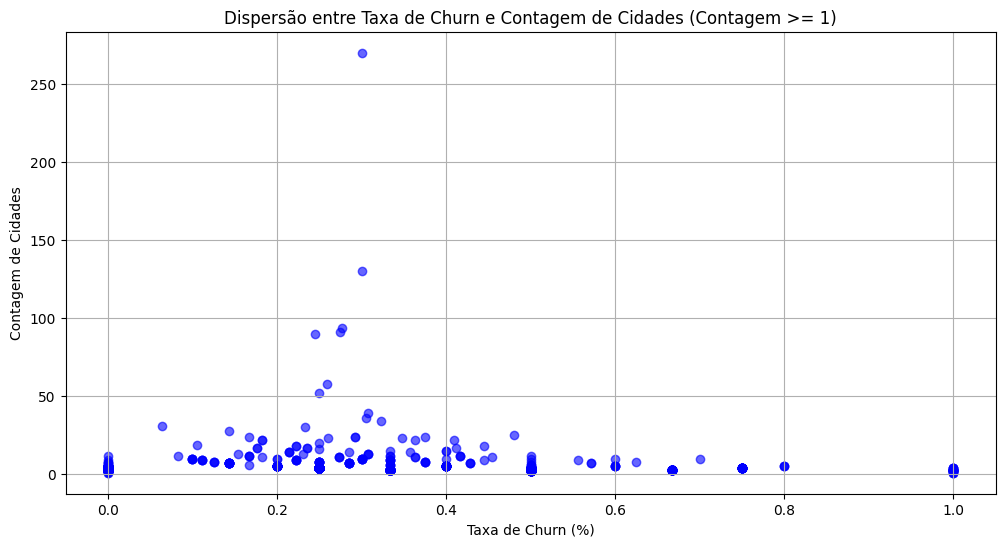

Para contagem >= 5:
  Valor Mínimo de Churn Rate: 0.00
  Valor Máximo de Churn Rate: 0.80
  Mediana de Churn Rate: 0.25
  Contagem de Valores de City: 233
--------------------------------------------------


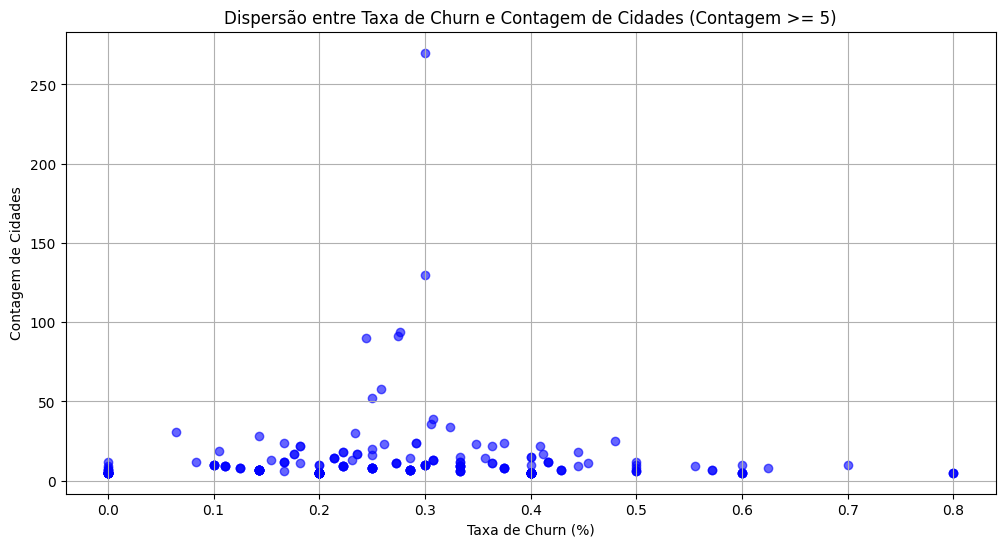

Para contagem >= 10:
  Valor Mínimo de Churn Rate: 0.00
  Valor Máximo de Churn Rate: 0.70
  Mediana de Churn Rate: 0.28
  Contagem de Valores de City: 83
--------------------------------------------------


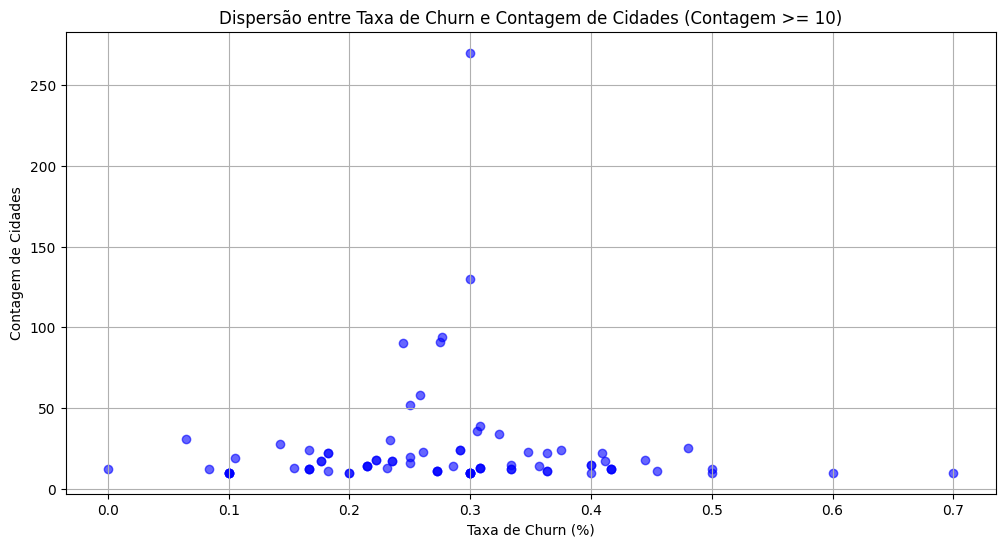

Para contagem >= 25:
  Valor Mínimo de Churn Rate: 0.06
  Valor Máximo de Churn Rate: 0.48
  Mediana de Churn Rate: 0.28
  Contagem de Valores de City: 14
--------------------------------------------------


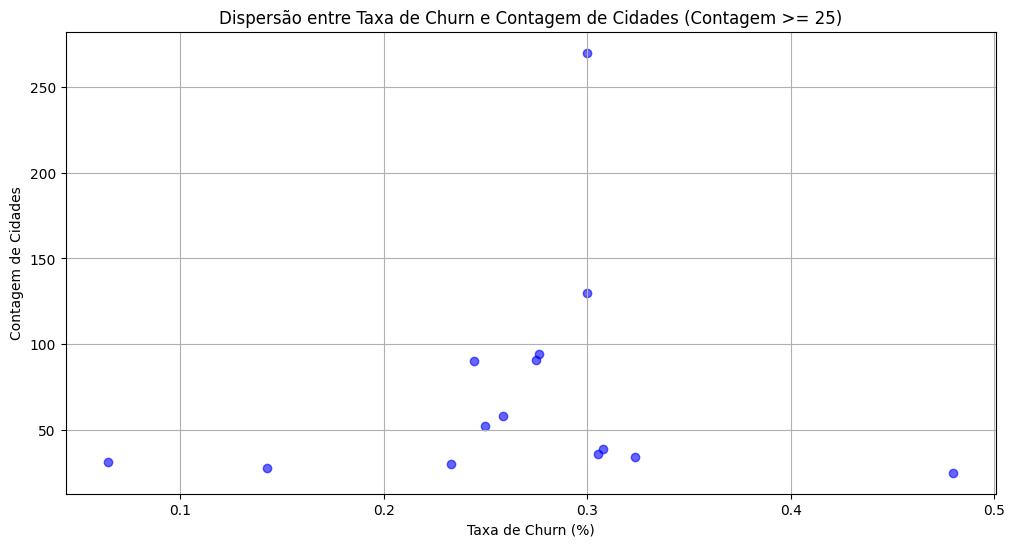

Para contagem >= 50:
  Valor Mínimo de Churn Rate: 0.24
  Valor Máximo de Churn Rate: 0.30
  Mediana de Churn Rate: 0.27
  Contagem de Valores de City: 7
--------------------------------------------------


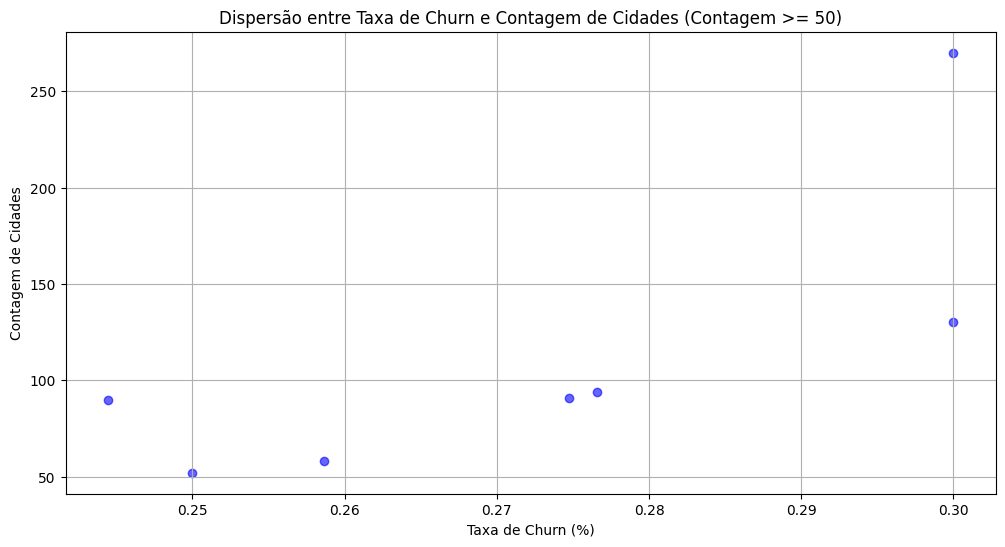

In [ ]:
import matplotlib.pyplot as plt

# Lista de valores para a contagem mínima, ordenada
values = [1, 5, 10, 25, 50]

for min_count in values:
    # Filtra as cidades com contagem maior ou igual a min_count
    filtered_df = city_churn_quartiles[city_churn_quartiles['Count'] >= min_count]

    # Calcula as estatísticas de Churn Rate
    min_churn_rate = filtered_df['Churn Rate'].min()
    max_churn_rate = filtered_df['Churn Rate'].max()
    median_churn_rate = filtered_df['Churn Rate'].median()
    count_city = filtered_df['City'].count()

    # Exibe as estatísticas
    print(f"Para contagem >= {min_count}:")
    print(f"  Valor Mínimo de Churn Rate: {min_churn_rate:.2f}")
    print(f"  Valor Máximo de Churn Rate: {max_churn_rate:.2f}")
    print(f"  Mediana de Churn Rate: {median_churn_rate:.2f}")
    print(f"  Contagem de Valores de City: {count_city}")
    print("-" * 50)

    # Cria o gráfico de dispersão
    plt.figure(figsize=(12, 6))
    plt.scatter(filtered_df['Churn Rate'], filtered_df['Count'], color='blue', alpha=0.6)

    # Adiciona títulos e rótulos aos eixos
    plt.title(f'Dispersão entre Taxa de Churn e Contagem de Cidades (Contagem >= {min_count})')
    plt.xlabel('Taxa de Churn (%)')
    plt.ylabel('Contagem de Cidades')

    # Exibe o gráfico
    plt.grid(True)
    plt.show()



In [ ]:
train_old['City'].nunique()


1129

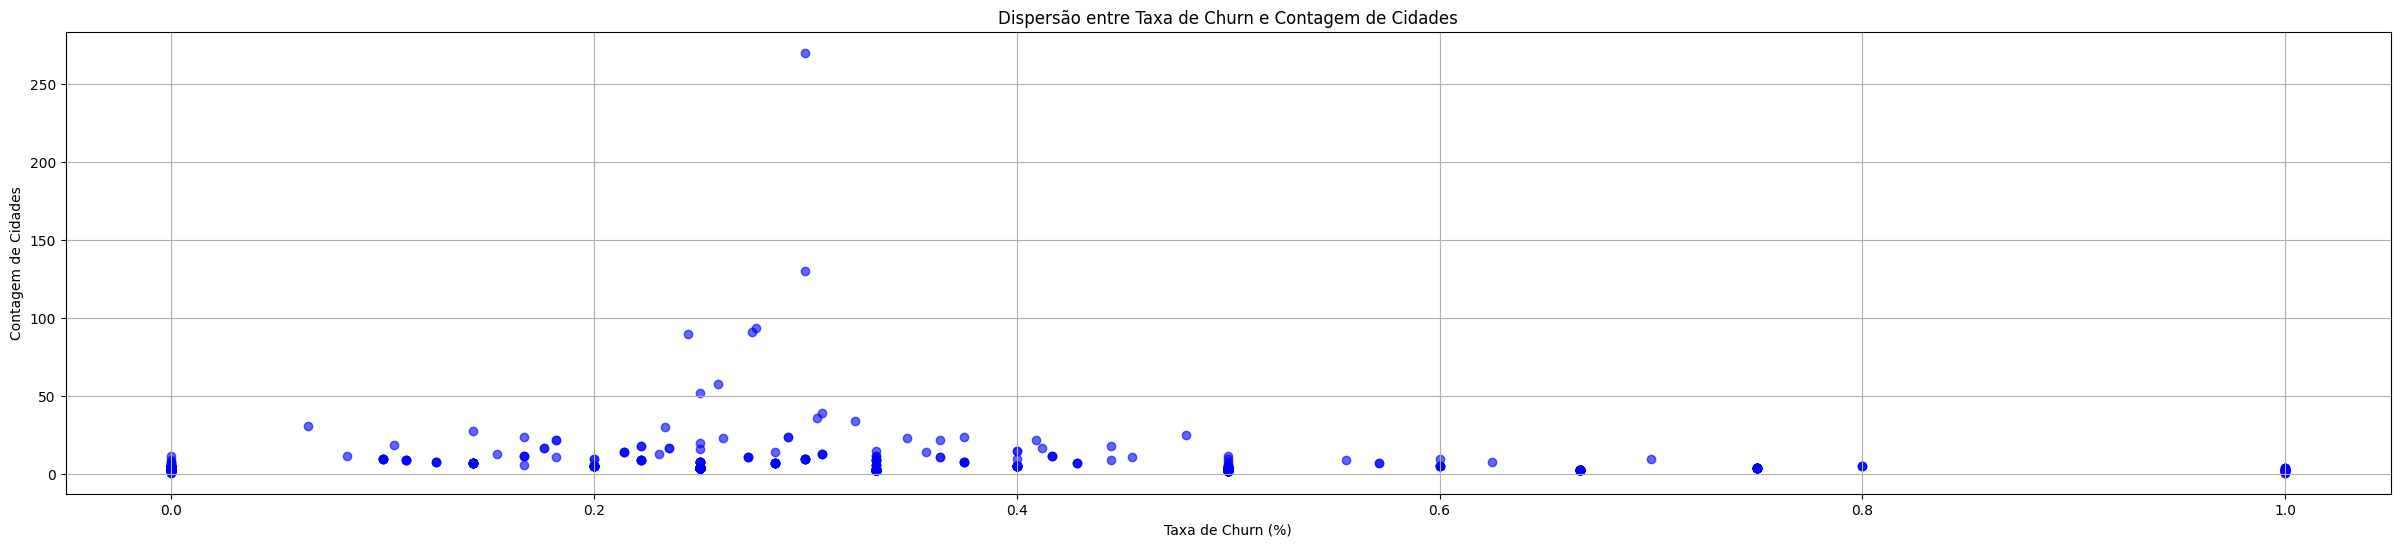

In [ ]:
import matplotlib.pyplot as plt

# Cria o gráfico de dispersão
plt.figure(figsize=(30, 6))
plt.scatter(city_churn_quartiles['Churn Rate'], city_churn_quartiles['Count'], color='blue', alpha=0.6)

# Adiciona títulos e rótulos aos eixos
plt.title('Dispersão entre Taxa de Churn e Contagem de Cidades')
plt.ylabel('Contagem de Cidades')
plt.xlabel('Taxa de Churn (%)')

# Exibe o gráfico
plt.grid(True)
plt.show()


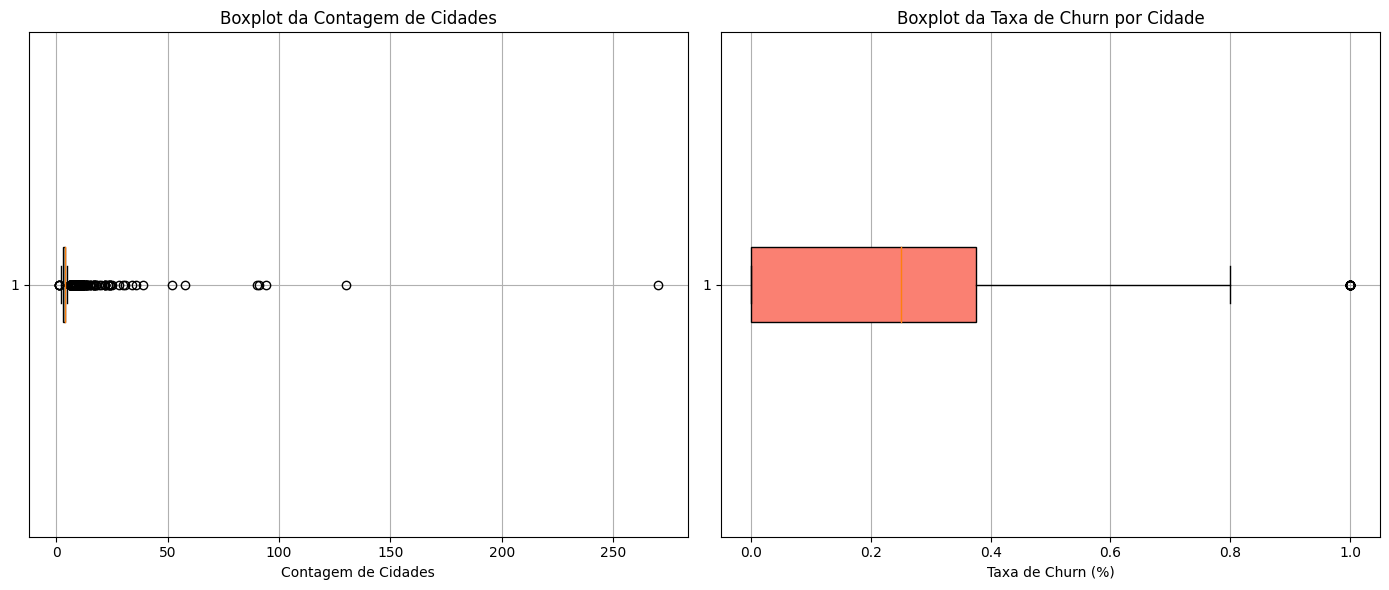

In [ ]:
import matplotlib.pyplot as plt

# Cria uma figura com dois subplots lado a lado
plt.figure(figsize=(14, 6))

# Boxplot para a distribuição da contagem de cidades
plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, 1º subplot
plt.boxplot(city_churn_quartiles['Count'], vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue'))
plt.title('Boxplot da Contagem de Cidades')
plt.xlabel('Contagem de Cidades')
plt.grid(True)

# Boxplot para a distribuição da taxa de churn
plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, 2º subplot
plt.boxplot(city_churn_quartiles['Churn Rate'], vert=False, patch_artist=True, boxprops=dict(facecolor='salmon'))
plt.title('Boxplot da Taxa de Churn por Cidade')
plt.xlabel('Taxa de Churn (%)')
plt.grid(True)

# Ajusta o layout para que os gráficos não se sobreponham
plt.tight_layout()
plt.show()


Para contagem >= 1:
  Valor Mínimo de Churn Rate: 0.00
  Valor Máximo de Churn Rate: 1.00
  Mediana de Churn Rate: 0.25
  Contagem de Valores de City: 1129
  Correlação entre Count e Churn Rate: 0.01
Até 10 cidades com a taxa de churn igual ao máximo (1.00):
  Cidade: Boulder Creek, Contagem: 4
  Cidade: Eldridge, Contagem: 3
  Cidade: Fort Jones, Contagem: 4
  Cidade: Elverta, Contagem: 2
  Cidade: Jamestown, Contagem: 1
  Cidade: Smith River, Contagem: 3
  Cidade: Old Station, Contagem: 3
  Cidade: Crockett, Contagem: 1
  Cidade: Maricopa, Contagem: 3
  Cidade: Amador City, Contagem: 2
--------------------------------------------------


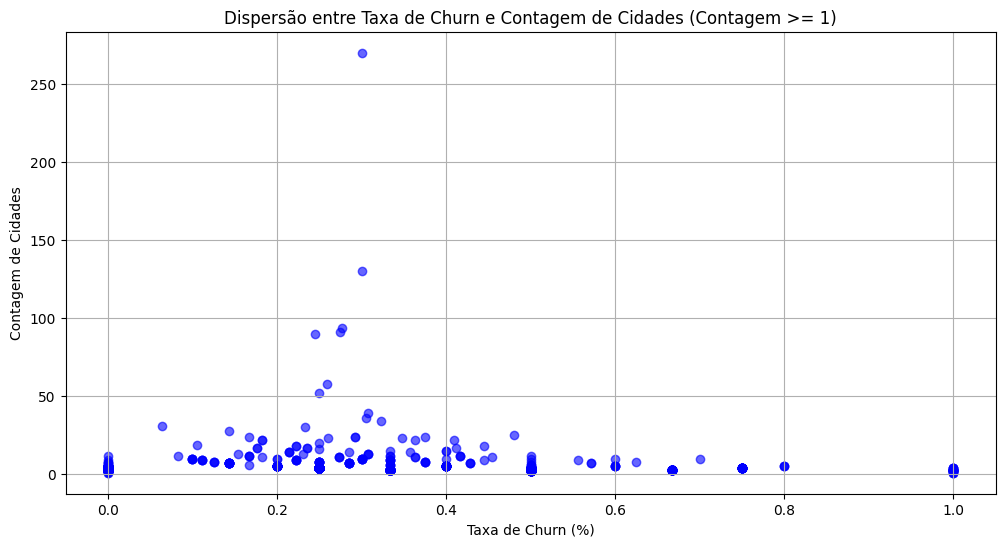

Para contagem >= 5:
  Valor Mínimo de Churn Rate: 0.00
  Valor Máximo de Churn Rate: 0.80
  Mediana de Churn Rate: 0.25
  Contagem de Valores de City: 233
  Correlação entre Count e Churn Rate: 0.01
Até 10 cidades com a taxa de churn igual ao máximo (0.80):
  Cidade: Panorama City, Contagem: 5
  Cidade: Indian Wells, Contagem: 5
  Cidade: San Dimas, Contagem: 5
--------------------------------------------------


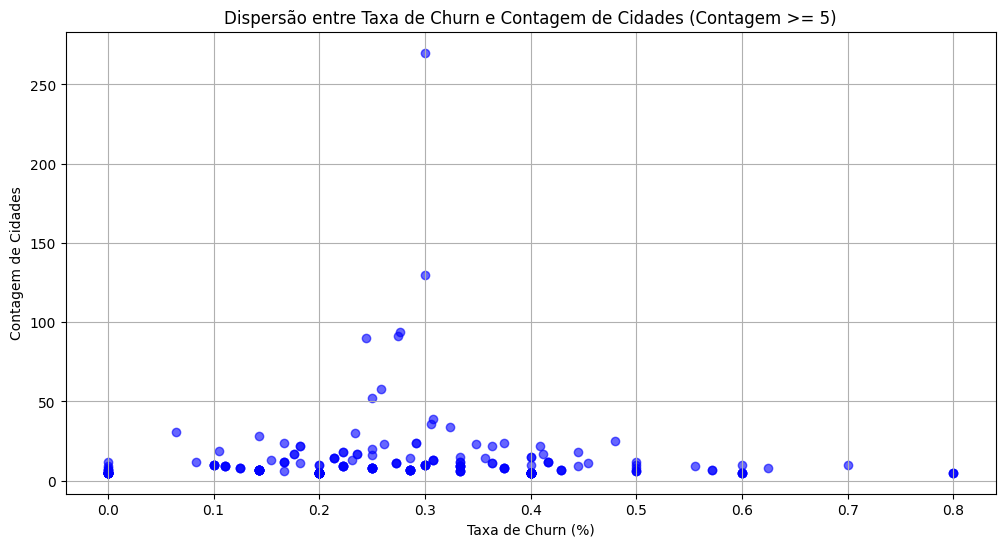

Para contagem >= 10:
  Valor Mínimo de Churn Rate: 0.00
  Valor Máximo de Churn Rate: 0.70
  Mediana de Churn Rate: 0.28
  Contagem de Valores de City: 83
  Correlação entre Count e Churn Rate: -0.00
Até 10 cidades com a taxa de churn igual ao máximo (0.70):
  Cidade: La Puente, Contagem: 10
--------------------------------------------------


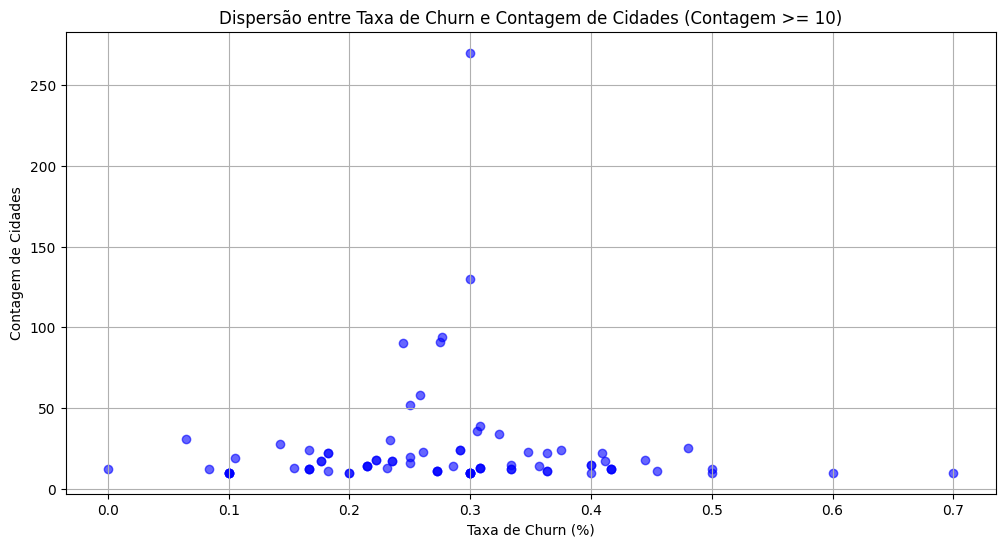

Para contagem >= 25:
  Valor Mínimo de Churn Rate: 0.06
  Valor Máximo de Churn Rate: 0.48
  Mediana de Churn Rate: 0.28
  Contagem de Valores de City: 14
  Correlação entre Count e Churn Rate: 0.12
Até 10 cidades com a taxa de churn igual ao máximo (0.48):
  Cidade: Modesto, Contagem: 25
--------------------------------------------------


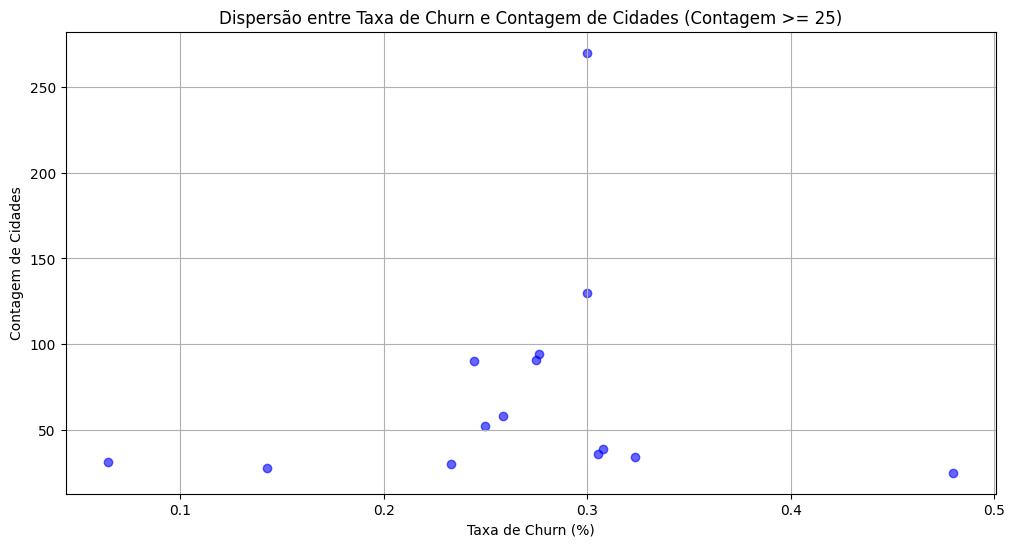

Para contagem >= 50:
  Valor Mínimo de Churn Rate: 0.24
  Valor Máximo de Churn Rate: 0.30
  Mediana de Churn Rate: 0.27
  Contagem de Valores de City: 7
  Correlação entre Count e Churn Rate: 0.74
Até 10 cidades com a taxa de churn igual ao máximo (0.30):
  Cidade: San Diego, Contagem: 130
  Cidade: Los Angeles, Contagem: 270
--------------------------------------------------


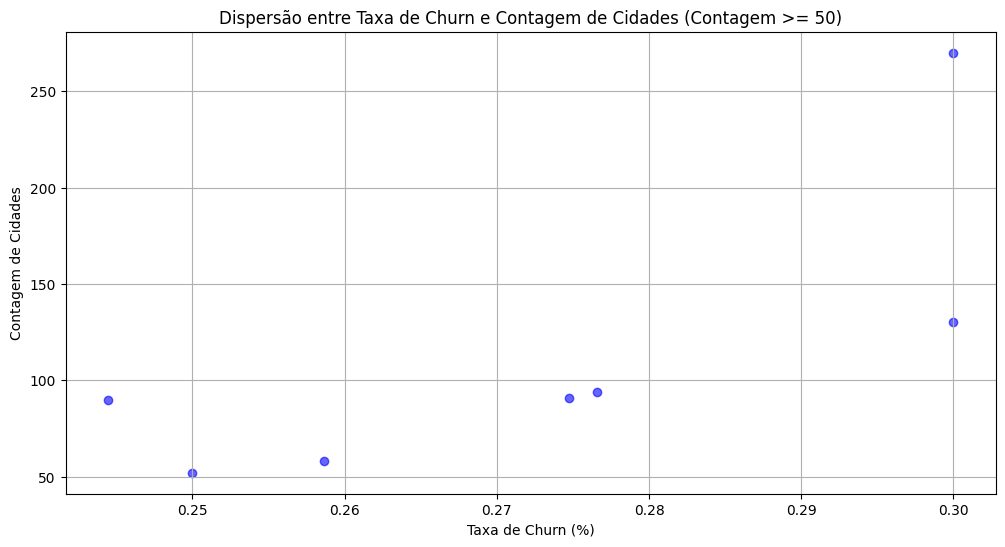

In [ ]:
import matplotlib.pyplot as plt

# Lista de valores para a contagem mínima, ordenada
values = [1, 5, 10, 25, 50]

for min_count in values:
    # Filtra as cidades com contagem maior ou igual a min_count
    filtered_df = city_churn_quartiles[city_churn_quartiles['Count'] >= min_count]

    # Calcula as estatísticas de Churn Rate
    min_churn_rate = filtered_df['Churn Rate'].min()
    max_churn_rate = filtered_df['Churn Rate'].max()
    median_churn_rate = filtered_df['Churn Rate'].median()
    count_city = filtered_df['City'].count()

    # Calcula a correlação entre Count e Churn Rate
    correlation = filtered_df[['Churn Rate', 'Count']].corr().iloc[0, 1]

    # Exibe as estatísticas
    print(f"Para contagem >= {min_count}:")
    print(f"  Valor Mínimo de Churn Rate: {min_churn_rate:.2f}")
    print(f"  Valor Máximo de Churn Rate: {max_churn_rate:.2f}")
    print(f"  Mediana de Churn Rate: {median_churn_rate:.2f}")
    print(f"  Contagem de Valores de City: {count_city}")
    print(f"  Correlação entre Count e Churn Rate: {correlation:.2f}")

    # Identifica e imprime até 10 cidades com o churn rate igual ao máximo churn rate
    top_cities = filtered_df[filtered_df['Churn Rate'] == max_churn_rate]

    # Ordena as cidades pelo count e seleciona no máximo 10
    top_cities = top_cities[['City', 'Count']].head(10)

    print(f"Até 10 cidades com a taxa de churn igual ao máximo ({max_churn_rate:.2f}):")
    for _, row in top_cities.iterrows():
        print(f"  Cidade: {row['City']}, Contagem: {row['Count']}")

    print("-" * 50)

    # Cria o gráfico de dispersão
    plt.figure(figsize=(12, 6))
    plt.scatter(filtered_df['Churn Rate'], filtered_df['Count'], color='blue', alpha=0.6)

    # Adiciona títulos e rótulos aos eixos
    plt.title(f'Dispersão entre Taxa de Churn e Contagem de Cidades (Contagem >= {min_count})')
    plt.xlabel('Taxa de Churn (%)')
    plt.ylabel('Contagem de Cidades')

    # Exibe o gráfico
    plt.grid(True)
    plt.show()



### O churn é mais prevalente entre clientes recentes ou antigos?

In [ ]:
train['Contract'].unique()

array([1, 3, 2])

Correlação entre Churn Label e Tenure Months: -0.35
Correlação entre Churn Label e Contract: -0.40
Primeiros valores médios para Tenure Months:
   Tenure Months  Churn Label
0              1     0.616105
1              2     0.523560
2              3     0.426901
3              4     0.469799
4              5     0.478632
Primeiros valores médios para Contract:
   Contract  Churn Label
0         1     0.425266
1         2     0.114126
2         3     0.025748


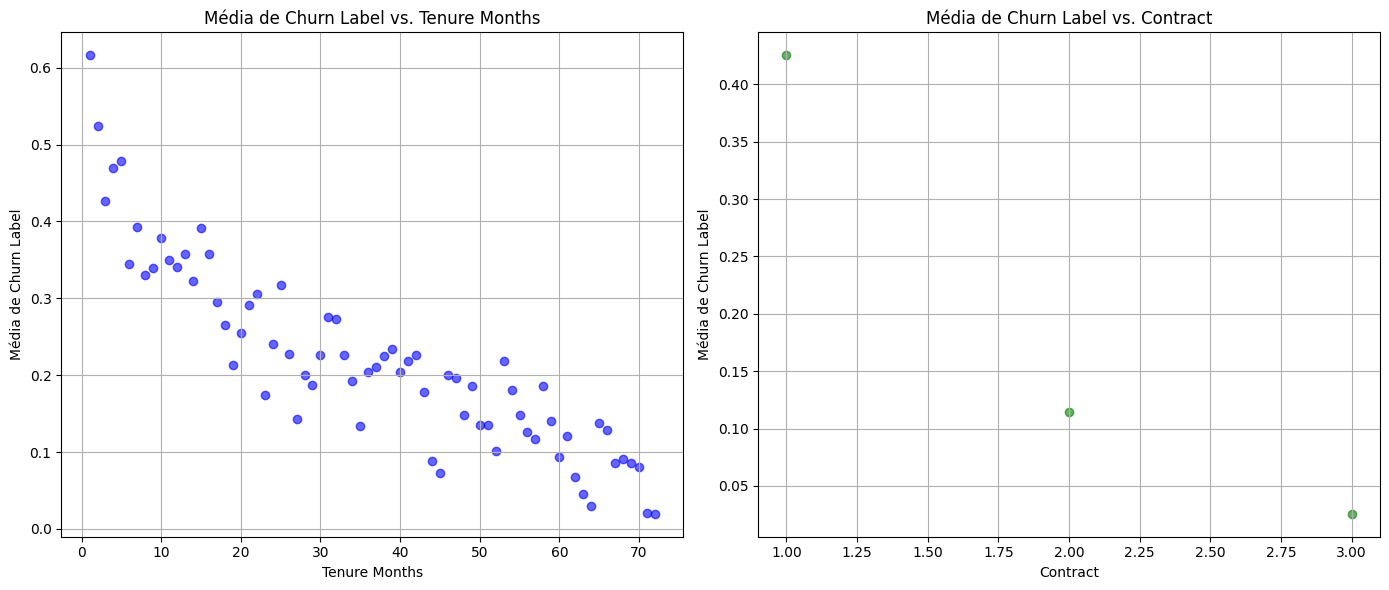

In [ ]:
import matplotlib.pyplot as plt

# Calcula a correlação entre Churn Label e Tenure Months
corr_churn_tenure = train[['Churn Label', 'Tenure Months']].corr().iloc[0, 1]

# Calcula a correlação entre Churn Label e Contract
corr_churn_contract = train[['Churn Label', 'Contract']].corr().iloc[0, 1]

# Exibe as correlações
print(f"Correlação entre Churn Label e Tenure Months: {corr_churn_tenure:.2f}")
print(f"Correlação entre Churn Label e Contract: {corr_churn_contract:.2f}")

import matplotlib.pyplot as plt

# Calcula a média de Churn Label para cada valor único de Tenure Months
tenure_churn_avg = train.groupby('Tenure Months')['Churn Label'].mean().reset_index()

# Calcula a média de Churn Label para cada valor único de Contract
contract_churn_avg = train.groupby('Contract')['Churn Label'].mean().reset_index()

# Exibe as correlações médias para Tenure Months e Contract
print(f"Primeiros valores médios para Tenure Months:\n{tenure_churn_avg.head()}")
print(f"Primeiros valores médios para Contract:\n{contract_churn_avg.head()}")

# Cria o gráfico de dispersão para a média de Churn Label vs. Tenure Months
plt.figure(figsize=(14, 6))

# Subplot 1: Média de Churn Label vs. Tenure Months
plt.subplot(1, 2, 1)
plt.scatter(tenure_churn_avg['Tenure Months'], tenure_churn_avg['Churn Label'], color='blue', alpha=0.6)
plt.title('Média de Churn Label vs. Tenure Months')
plt.xlabel('Tenure Months')
plt.ylabel('Média de Churn Label')
plt.grid(True)

# Subplot 2: Média de Churn Label vs. Contract
plt.subplot(1, 2, 2)
plt.scatter(contract_churn_avg['Contract'], contract_churn_avg['Churn Label'], color='green', alpha=0.6)
plt.title('Média de Churn Label vs. Contract')
plt.xlabel('Contract')
plt.ylabel('Média de Churn Label')
plt.grid(True)

# Ajusta o layout e exibe os gráficos
plt.tight_layout()
plt.show()



### Quais serviços são menos utilizados?

Online Security      28.317992
Tech Support         29.104603
Online Backup        34.142259
Device Protection    34.343096
Streaming TV         37.991632
Streaming Movies     38.828452
Multiple Lines       41.891213
Phone Service        90.242678
dtype: float64


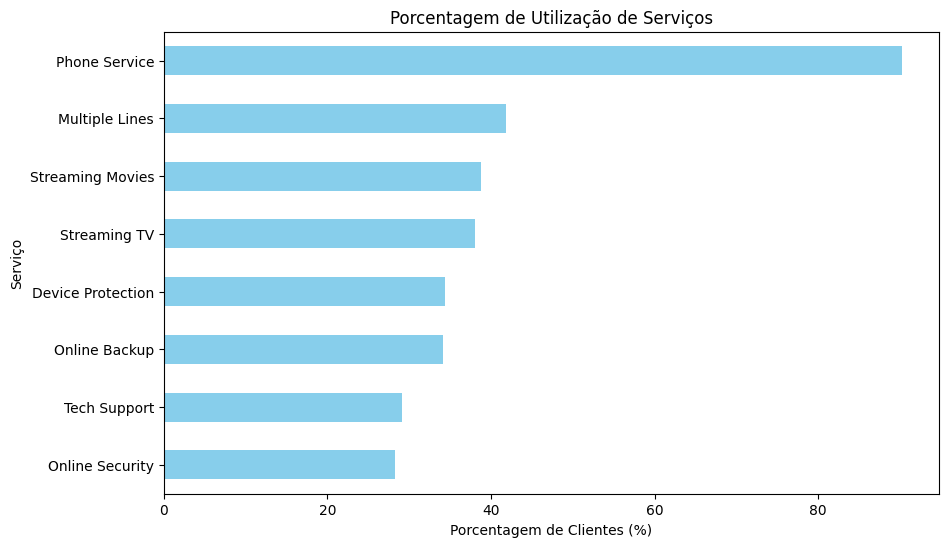

In [ ]:
import pandas as pd

# Seleciona as colunas referentes aos serviços
service_columns = ['Phone Service', 'Multiple Lines', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies']

# Calcula a porcentagem de clientes que possuem cada serviço
service_usage = train[service_columns].mean() * 100

# Ordena os serviços pelo menor uso
service_usage_sorted = service_usage.sort_values()

# Exibe os serviços menos utilizados
print(service_usage_sorted)

# Visualiza os serviços menos utilizados em um gráfico de barras
service_usage_sorted.plot(kind='barh', figsize=(10, 6), color='skyblue')
plt.title('Porcentagem de Utilização de Serviços')
plt.xlabel('Porcentagem de Clientes (%)')
plt.ylabel('Serviço')
plt.show()


# Modelos

In [ ]:
from sklearn.model_selection import train_test_split

# Defina X como todas as colunas que serão utilizadas como features e y como a coluna 'Churn Label'
X = train.drop(columns=['Churn Label'])
y = train['Churn Label']

# Divida os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Árvore de Decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

y_pred_tree = decision_tree.predict(X_test)

# Avaliação da Árvore de Decisão
print("Árvore de Decisão:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_tree):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred_tree):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_tree):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_tree):.2f}")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_tree))

Árvore de Decisão:
Acurácia: 0.74
Precisão: 0.52
Recall: 0.48
F1-Score: 0.50

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.81      0.84      0.82       867
           1       0.52      0.48      0.50       328

    accuracy                           0.74      1195
   macro avg       0.67      0.66      0.66      1195
weighted avg       0.73      0.74      0.73      1195



## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train)

y_pred_forest = random_forest.predict(X_test)

# Avaliação da Floresta Aleatória
print("\nFloresta Aleatória:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_forest):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred_forest):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_forest):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_forest):.2f}")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_forest))


Floresta Aleatória:
Acurácia: 0.81
Precisão: 0.73
Recall: 0.46
F1-Score: 0.57

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       867
           1       0.73      0.46      0.57       328

    accuracy                           0.81      1195
   macro avg       0.77      0.70      0.72      1195
weighted avg       0.80      0.81      0.79      1195



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Defina os parâmetros que você deseja ajustar
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Crie uma instância do GridSearchCV
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',  # Ajuste para maximizar o F1-score
    n_jobs=-1
)

# Ajuste o modelo
grid_search.fit(X_train, y_train)

# Obtenha o melhor modelo
best_rf = grid_search.best_estimator_

# Faça previsões com o melhor modelo
y_pred_rf = best_rf.predict(X_test)

# Avalie o desempenho do modelo ajustado
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

print("Random Forest Ajustado:")
print(f"Acurácia: {accuracy_score(y_test, y_pred_rf):.2f}")
print(f"Precisão: {precision_score(y_test, y_pred_rf):.2f}")
print(f"Recall: {recall_score(y_test, y_pred_rf):.2f}")
print(f"F1-Score: {f1_score(y_test, y_pred_rf):.2f}")
print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred_rf))



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
540 fits failed out of a total of 1620.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
540 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/uti

Random Forest Ajustado:
Acurácia: 0.80
Precisão: 0.72
Recall: 0.45
F1-Score: 0.55

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.82      0.93      0.87       867
           1       0.72      0.45      0.55       328

    accuracy                           0.80      1195
   macro avg       0.77      0.69      0.71      1195
weighted avg       0.79      0.80      0.78      1195



### Aplicação

Árvore de Decisão

In [ ]:
# Remova a coluna 'CustomerID' e 'Churn Label' se estiver presente em 'test'
test_features = test.drop(columns=['CustomerID', 'Churn Label'], errors='ignore')

# Garantir que as colunas estejam na mesma ordem que no treino
test_features = test_features[X_train.columns]

# Faça previsões usando o modelo de Árvore de Decisão
test['Churn Label'] = decision_tree.predict(test_features)

# Substitua os valores 0 e 1 por 'No' e 'Yes'
test['Churn Label'] = test['Churn Label'].replace({0: 'No', 1: 'Yes'})

# Se precisar manter a coluna 'CustomerID', você pode fazer isso
test_with_ids = test[['CustomerID', 'Churn Label']]

# Salve o DataFrame com as previsões em um arquivo CSV
test_with_ids.to_csv('test_with_churn_labels_decision_tree.csv', index=False)

print("Previsões da Árvore de Decisão foram salvas em 'test_with_churn_labels_decision_tree.csv'.")


Previsões da Árvore de Decisão foram salvas em 'test_with_churn_labels_decision_tree.csv'.


Random Forest

In [ ]:
# Remova a coluna 'CustomerID' de 'test'
test_features = test.drop(columns=['CustomerID'], errors='ignore')

# Garanta que as colunas de 'test_features' estejam na mesma ordem que 'X_train'
test_features = test_features[X_train.columns]

# Use o modelo treinado para fazer previsões
test['Churn Label'] = best_rf.predict(test_features)

# Se precisar manter a coluna 'CustomerID', você pode fazer isso:
test_with_ids = test[['CustomerID', 'Churn Label']]

# Substitua os valores 0 e 1 por 'No' e 'Yes'
test_with_ids['Churn Label'] = test_with_ids['Churn Label'].replace({0: 'No', 1: 'Yes'})

# Salve o DataFrame com as previsões em um arquivo CSV
test_with_ids.to_csv('test_with_churn_labels_random_forest_2.csv', index=False)

print("Previsões da Random Forest foram salvas em 'test_with_churn_labels_random_forest_2.csv'.")


Previsões da Random Forest foram salvas em 'test_with_churn_labels_random_forest_2.csv'.


<ipython-input-261-e5b1d2e8ecb5>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_with_ids['Churn Label'] = test_with_ids['Churn Label'].replace({0: 'No', 1: 'Yes'})


In [ ]:
# Remova a coluna 'CustomerID' de 'test'
test_features = test.drop(columns=['CustomerID'], errors='ignore')

# Garanta que as colunas de 'test_features' estejam na mesma ordem que 'X_train'
test_features = test_features[X_train.columns]

# Use o modelo treinado para fazer previsões
test['Churn Label'] = random_forest.predict(test_features)

# Se precisar manter a coluna 'CustomerID', você pode fazer isso:
test_with_ids = test[['CustomerID', 'Churn Label']]

# Substitua os valores 0 e 1 por 'No' e 'Yes'
test_with_ids['Churn Label'] = test_with_ids['Churn Label'].replace({0: 'No', 1: 'Yes'})

# Salve o DataFrame com as previsões em um arquivo CSV
test_with_ids.to_csv('test_with_churn_labels_random_forest.csv', index=False)

print("Previsões da Random Forest foram salvas em 'test_with_churn_labels_random_forest.csv'.")

Previsões da Random Forest foram salvas em 'test_with_churn_labels_random_forest.csv'.


<ipython-input-260-0b7e8bd1b8e8>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_with_ids['Churn Label'] = test_with_ids['Churn Label'].replace({0: 'No', 1: 'Yes'})
